# Добро пожаловать на задание уровня Ultra Pro.
Создайте Seq2Seq сеть для предсказания временного ряда. Можно воспользоваться любым временным рядом из предыдущих заданий или создать его самостотельно

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

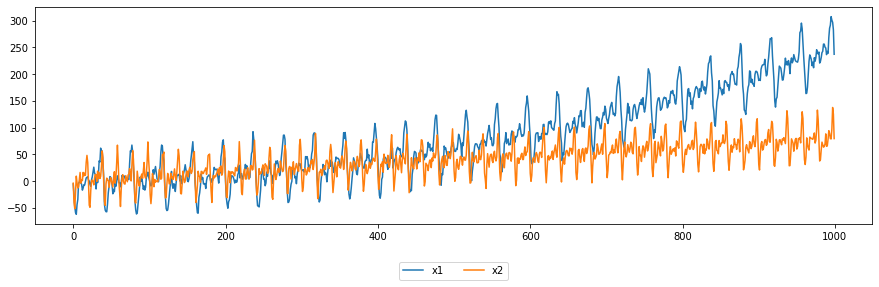

In [ ]:
n_ = 1000 # 1000 моментов времени
t = np.linspace(0, 50*np.pi, n_)
# образец + тренд + шум
# Создадим 2 временных ряда
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_) 
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
train_ratio = 0.8 # размер обучающей выборки
train_len = int(train_ratio * t.shape[0])
print(train_len)

800


In [ ]:
x_index = np.array(range(len(t))) # индексы от 0 до 1000

In [ ]:
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2) # находим коэффициенты квадратного выражения для первого временного ряда
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1) # находим коэффициенты линейного выражения для второго временного ряда
print(x1_trend_param)
print(x2_trend_param)

[ 2.44187222e-04  8.81546968e-03 -2.58742083e+00]
[ 0.07984737 -0.23075163]


In [ ]:
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2] # создаём квадратное выражение для первого временного ряда
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1] # создаём линейное выражение для второго временного ряда

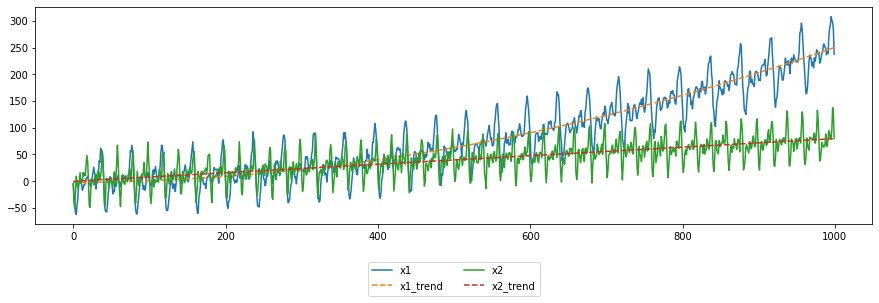

In [ ]:
# Выводим графики наших рядов и их приближений
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

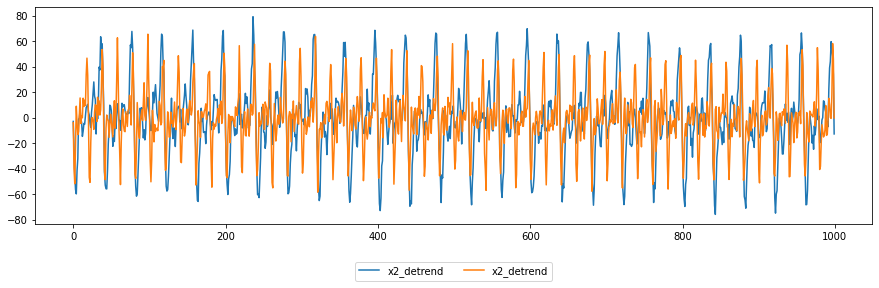

In [ ]:
# Вычитаем тренды и тсроим графики
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)]) # Объединяем ряды в одну матрицу
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[-2.81636887e+00 -3.80888549e+00  0.00000000e+00  1.00000000e+00]
 [-2.31595715e+01 -3.95014377e+01  1.00000000e+00  1.00000000e+00]
 [-4.54990062e+01 -5.16781446e+01  2.00000000e+00  1.00000000e+00]
 ...
 [ 4.81827894e+01  5.83098228e+01  9.97000000e+02  0.00000000e+00]
 [ 3.37442522e+01  4.58404794e+01  9.98000000e+02  0.00000000e+00]
 [-1.26271501e+01 -6.68939686e-02  9.99000000e+02  0.00000000e+00]]


In [ ]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0) # нормализуем по максимальному элементу
x_train_max = x_train_max.tolist()+[1]*2  # Сделаем нормализацию только для первых двух столбцов
print(x_train_max)

[79.30948944300432, 65.6094677325096, 1, 1]


In [ ]:
x_normalize = np.divide(x_lbl, x_train_max) # Нормализуем значения
print(x_normalize)

[[-3.55111209e-02 -5.80539002e-02  0.00000000e+00  1.00000000e+00]
 [-2.92015139e-01 -6.02069168e-01  1.00000000e+00  1.00000000e+00]
 [-5.73689309e-01 -7.87662915e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 6.07528679e-01  8.88740983e-01  9.97000000e+02  0.00000000e+00]
 [ 4.25475594e-01  6.98686957e-01  9.98000000e+02  0.00000000e+00]
 [-1.59213610e-01 -1.01957798e-03  9.99000000e+02  0.00000000e+00]]


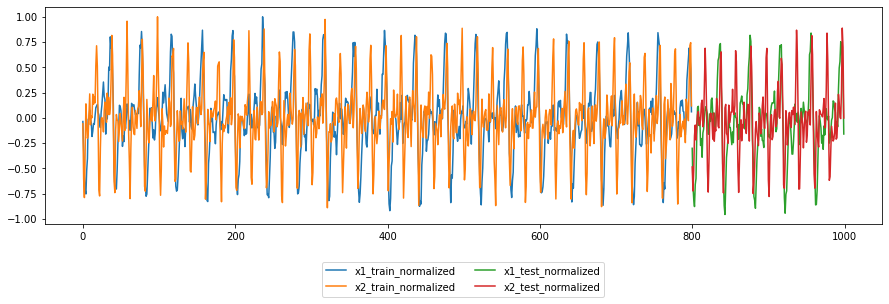

In [ ]:
# Строим нормализованные графики наших рядов
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
# Разделим ряд на участки равной длины
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=200, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


In [ ]:
# Разделим данные на входные/выходные тренировочные/тестовые
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


In [ ]:
# Создаём модель
# Input слой
n_hidden = 100
# 2 входных слоя для входа/выхода
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

In [ ]:
# нужно вернуть последние состояния h1,h2,c
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train) # LSTM - слой для входных данных

In [ ]:
# Нормализуем состояния среды
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [ ]:

decoder = RepeatVector(output_train.shape[1])(encoder_last_h1) # копируем 20 раз послденее скрытое состояние энкодера
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c]) # LSTM - слой теперь для декодера


In [ ]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder) # TimeDistributed позволяет нам применять слой к каждому временному фрагменту ввода

In [ ]:
# Собираем модель, настраиваем оптимизатор, задаем метрики и выводим структуру модели
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 2)]     0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 100),        41200       ['input_3[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 100)         400         ['lstm_2[0][0]']                 
 rmalization)                                                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


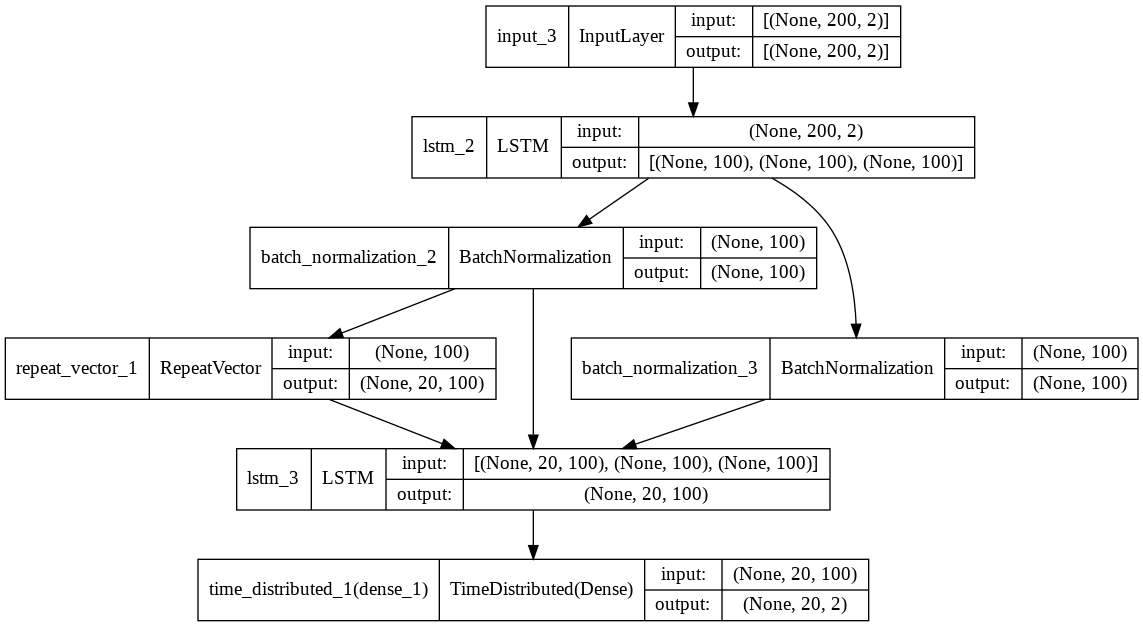

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=100, verbose=1, 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

Epoch 1/100
5/5 [==============================] - 8s 828ms/step - loss: 4.1100 - mae: 1.0136 - val_loss: 0.1402 - val_mae: 0.2876
Epoch 2/100
5/5 [==============================] - 3s 712ms/step - loss: 0.2072 - mae: 0.3431 - val_loss: 0.1282 - val_mae: 0.2674
Epoch 3/100
5/5 [==============================] - 4s 723ms/step - loss: 0.1266 - mae: 0.2627 - val_loss: 0.1153 - val_mae: 0.2538
Epoch 4/100
5/5 [==============================] - 3s 691ms/step - loss: 0.1165 - mae: 0.2503 - val_loss: 0.1103 - val_mae: 0.2471
Epoch 5/100
5/5 [==============================] - 4s 727ms/step - loss: 0.1113 - mae: 0.2425 - val_loss: 0.1038 - val_mae: 0.2384
Epoch 6/100
5/5 [==============================] - 4s 722ms/step - loss: 0.1074 - mae: 0.2384 - val_loss: 0.1008 - val_mae: 0.2365
Epoch 7/100
5/5 [==============================] - 4s 710ms/step - loss: 0.1034 - mae: 0.2347 - val_loss: 0.0982 - val_mae: 0.2346
Epoch 8/100
5/5 [==============================] - 4s 713ms/step - loss: 0.1015 - m

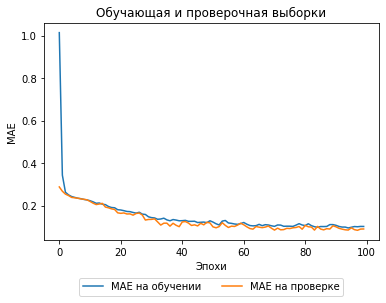

In [ ]:
plt.plot(train_mae, label='МАЕ на обучении'), 
plt.plot(valid_mae, label='МАЕ на проверке')
plt.ylabel('МАЕ')
plt.xlabel('Эпохи')
plt.title('Обучающая и проверочная выборки')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
# Делаем предсказание результата
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


In [ ]:
#Объединяем результаты и индексы
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [ ]:
# отправляем выходные данные в словарь
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


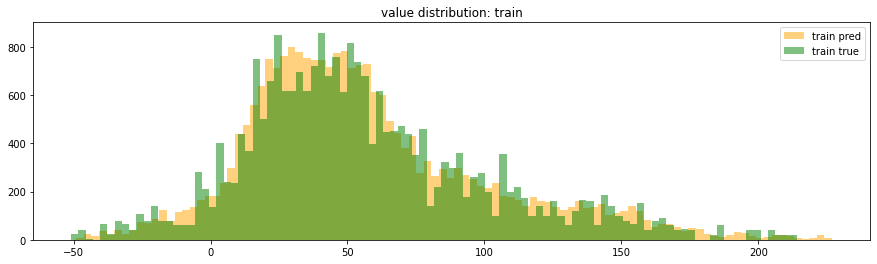

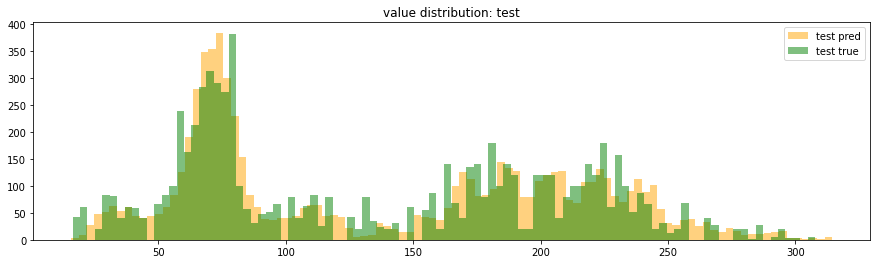

In [ ]:
# Выведем гистограммы данных
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

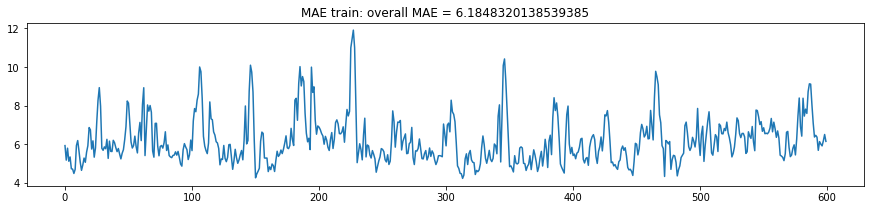

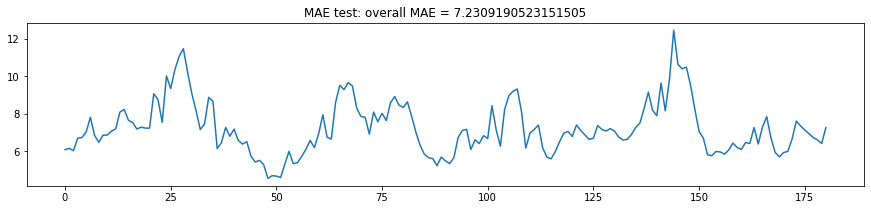

In [ ]:
# Выведем график MAE
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

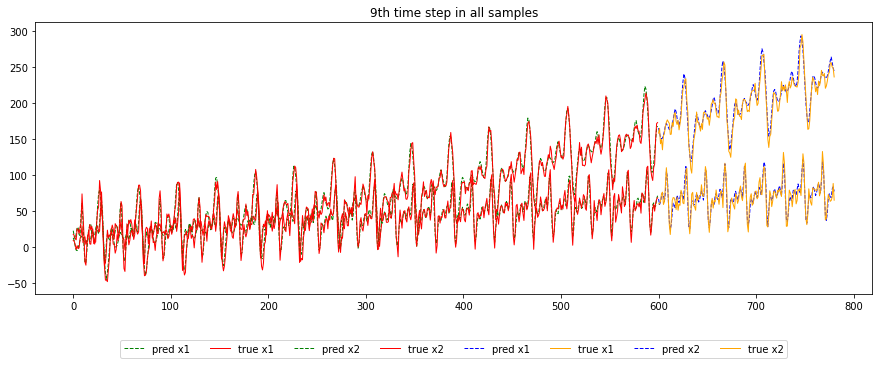

In [ ]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()